In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
feature_files = {
    "Lexical": "/kaggle/input/cogdis-data/lexical_features.csv",
    "Syntactic": "/kaggle/input/cogdis-data/syntactic_features.csv",
    "Sentiment": "/kaggle/input/cogdis-data/Sentiment Emotion Features.csv",
    "Interaction": "/kaggle/input/cogdis-data/Interaction_features.csv",
    "Semantic": "/kaggle/input/cogdis-data/Semantic_features_phobert_10bias.csv"
}

drop_cols = [
    'Original Text','clean_text',
    'Emotional Reasoning','Overgeneralization','Should Statements',
    'Personalization','Mental Filter','Disqualifying the Positive',
    'Jumping to Conclusions','Labeling and Mislabeling',
    'Magnification and Minimization','All-or-Nothing Thinking','Label'
]

In [3]:
def safe_label_extract(df):
    """Tìm cột Label (không phân biệt hoa thường)"""
    label_cols = [c for c in df.columns if c.lower() == 'label']
    if len(label_cols) == 0:
        return None
    return df[label_cols[0]]

def encode_categorical_columns(X):
    """Mã hóa các cột dạng chuỗi"""
    for col in X.columns:
        if X[col].dtype == 'object':
            unique_vals = X[col].nunique()
            if unique_vals <= 10:
                X = pd.concat([X.drop(columns=[col]), pd.get_dummies(X[col], prefix=col)], axis=1)
            else:
                le = LabelEncoder()
                X[col] = le.fit_transform(X[col].astype(str))
    return X

def evaluate_model(X_train, X_test, y_train, y_test, model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return acc, f1


In [4]:
lexical_ref = pd.read_csv(feature_files["Lexical"])[["Original Text", "Label"]]

In [5]:
def evaluate_featureset(name, path):
    print(f"\n📂 Đang xử lý: {name}")
    df = pd.read_csv(path)

    # Nếu không có cột Label thì ghép từ file Lexical
    y = safe_label_extract(df)
    if y is None:
        df = df.merge(lexical_ref, on="Original Text", how="left")
        y = df["Label"]

    X = df.drop(columns=drop_cols, errors='ignore')

    # Encode và chuẩn hóa
    X = encode_categorical_columns(X)
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )

    models = {
        "Logistic Regression": LogisticRegression(max_iter=2000),
        "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42)
    }

    results = []
    for model_name, model in models.items():
        acc, f1 = evaluate_model(X_train, X_test, y_train, y_test, model, model_name)
        print(f"✅ {name} | {model_name} → Acc: {acc:.3f}, F1: {f1:.3f}")
        results.append({
            "Feature Set": name,
            "Model": model_name,
            "Accuracy": acc,
            "F1-score": f1
        })
    return results

In [6]:
all_results = []
for name, path in feature_files.items():
    try:
        res = evaluate_featureset(name, path)
        all_results.extend(res)
    except Exception as e:
        print(f"❌ Lỗi khi xử lý {name}: {e}")

df_results = pd.DataFrame(all_results)
print("\n=== 📈 KẾT QUẢ TỔNG HỢP ===")
print(df_results)


📂 Đang xử lý: Lexical
✅ Lexical | Logistic Regression → Acc: 0.803, F1: 0.875
✅ Lexical | Random Forest → Acc: 0.799, F1: 0.878

📂 Đang xử lý: Syntactic
✅ Syntactic | Logistic Regression → Acc: 0.782, F1: 0.877
✅ Syntactic | Random Forest → Acc: 0.775, F1: 0.869

📂 Đang xử lý: Sentiment
✅ Sentiment | Logistic Regression → Acc: 0.748, F1: 0.856
✅ Sentiment | Random Forest → Acc: 0.699, F1: 0.811

📂 Đang xử lý: Interaction
✅ Interaction | Logistic Regression → Acc: 0.743, F1: 0.852
✅ Interaction | Random Forest → Acc: 0.736, F1: 0.837

📂 Đang xử lý: Semantic
✅ Semantic | Logistic Regression → Acc: 0.754, F1: 0.854
✅ Semantic | Random Forest → Acc: 0.765, F1: 0.857

=== 📈 KẾT QUẢ TỔNG HỢP ===
   Feature Set                Model  Accuracy  F1-score
0      Lexical  Logistic Regression  0.802936  0.875000
1      Lexical        Random Forest  0.799453  0.878468
2    Syntactic  Logistic Regression  0.781678  0.877463
3    Syntactic        Random Forest  0.775471  0.868924
4    Sentiment  Logi

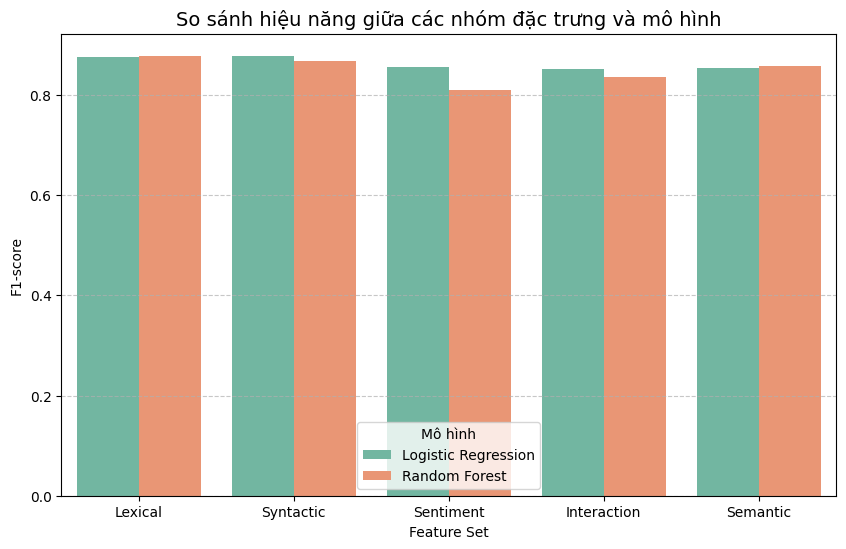

In [7]:
plt.figure(figsize=(10,6))
sns.barplot(data=df_results, x="Feature Set", y="F1-score", hue="Model", palette="Set2")
plt.title("So sánh hiệu năng giữa các nhóm đặc trưng và mô hình", fontsize=14)
plt.ylabel("F1-score")
plt.legend(title="Mô hình")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [8]:
df_results.to_csv("feature_model_comparison_results.csv", index=False)